In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from torch.utils.data import DataLoader

from dataloader.ts_reader import MultiModalDataset, collate_fn
from dataloader.pyg_reader import GraphDataset
from model.loss_train_final import *
from model.final_model import PatientOutcomeModel
from model.autoencoder_ts import RecurrentAutoencoder

import pickle
from sklearn.manifold import TSNE
import numpy as np 
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.synchronize()

from torch.amp import GradScaler, autocast
scaler = GradScaler() 


In [2]:
# === LSTM + Flat Dataset ===
train_data_dir = "/home/mei/nas/docker/thesis/data/hdf/train"
val_data_dir = "/home/mei/nas/docker/thesis/data/hdf/val"
test_data_dir = "/home/mei/nas/docker/thesis/data/hdf/test"

lstm_dataset_train = MultiModalDataset(train_data_dir)
lstm_dataset_val = MultiModalDataset(val_data_dir)
lstm_dataset_test = MultiModalDataset(test_data_dir)

train_loader = DataLoader(lstm_dataset_train , batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(lstm_dataset_val , batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(lstm_dataset_test , batch_size=32, shuffle=False, collate_fn=collate_fn)

config = {  
    "data_dir": "/home/mei/nas/docker/thesis/data/hdf",
    "graph_dir": "/home/mei/nas/docker/thesis/data/graphs",
    "mode": "k_closest",
    "k": 3         
}
graph_dataset = GraphDataset(config)


==> Loading precomputed graph from /home/mei/nas/docker/thesis/data/graphs/diagnosis_graph_k_closest_k3.pt
==> Loading flat features from /home/mei/nas/docker/thesis/data/hdf/final_flat.h5


In [3]:
save_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth'
history_path = '/home/mei/nas/docker/thesis/data/model_results/final_model/history.json'

flat_input_dim = 104
# ts_input_dim = 154
hidden_dim = 128
graph_input_dim = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


pretrained = RecurrentAutoencoder(n_features=154, embedding_dim=128,n_heads=2).to(device)
pretrained.load_state_dict(torch.load("/home/mei/nas/docker/thesis/data/model_results/pre_train/best_model_2.pth",weights_only=True ))
pretrained_encoder = pretrained.encoder
som = pretrained.som

model = PatientOutcomeModel(flat_input_dim,graph_input_dim, hidden_dim,som=som,pretrained_encoder=pretrained_encoder).to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [5]:
model,history = train_patient_outcome_model(model, train_loader, val_loader, graph_dataset.graph_data,optimizer, device, n_epochs=150, save_path=save_path, history_path=history_path,patience=50)

Epoch 10: Train 0.0065, Val 0.0076
Epoch 20: Train 0.0056, Val 0.0074
Epoch 30: Train 0.0047, Val 0.0076
Epoch 40: Train 0.0040, Val 0.0077
Epoch 50: Train 0.0035, Val 0.0079
Epoch 60: Train 0.0024, Val 0.0088
Epoch 70: Train 0.0019, Val 0.0090
Early stopping triggered.


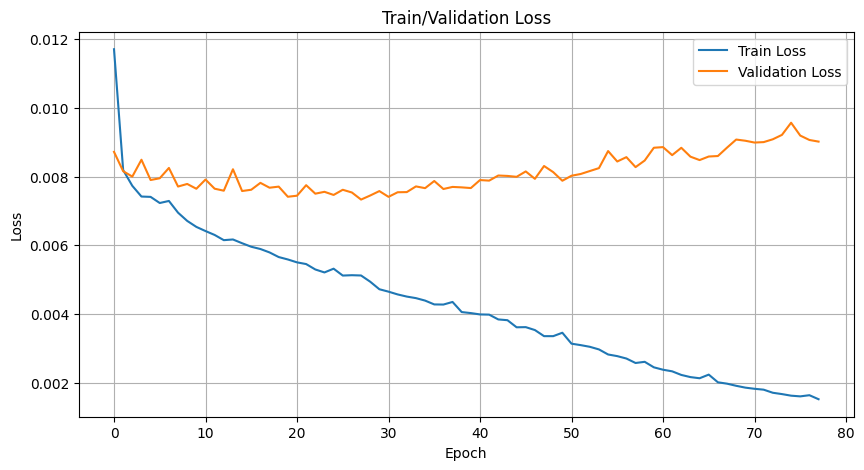

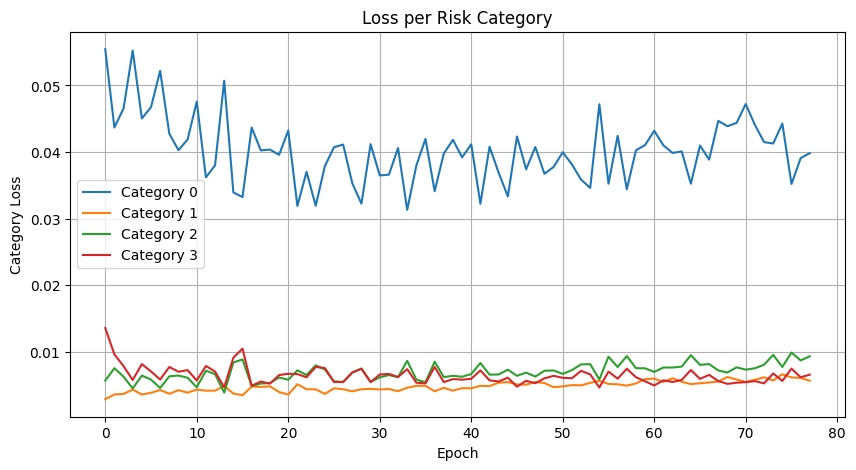

In [6]:
plot_training_history(history)

In [4]:
model.load_state_dict(torch.load('/home/mei/nas/docker/thesis/data/model_results/final_model/best_model.pth',weights_only=True))
result = evaluate_model_on_test_set(model, test_loader, graph_dataset.graph_data, device)



Test Evaluation Summary:
  Risk Category 0: Mean Loss = 0.0288, Count = 27
  Risk Category 1: Mean Loss = 0.0053, Count = 294
  Risk Category 2: Mean Loss = 0.0084, Count = 89
  Risk Category 3: Mean Loss = 0.0075, Count = 51


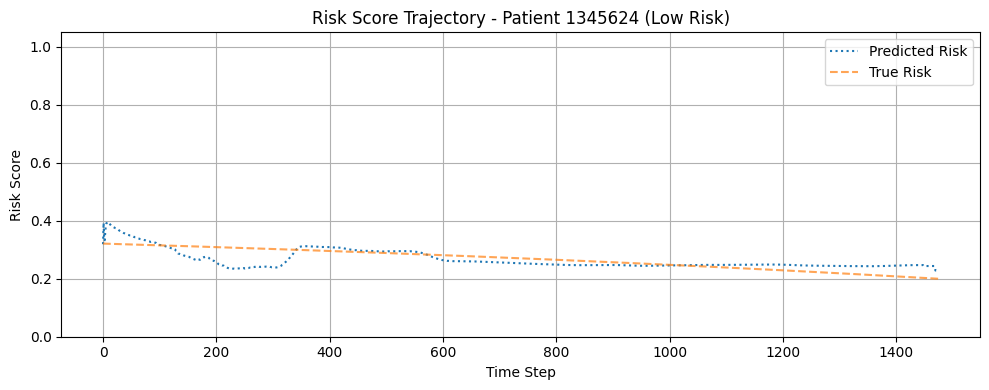

In [11]:
plot_patient_risk_trajectory(model, test_loader, patient_index=32, graph_data=graph_dataset.graph_data, device=device)

In [21]:
def collect_k_and_category(model, loader, graph_data, device):
    model.eval()
    all_k, all_cat, all_risk = [], [], []

    with torch.no_grad():
        for batch in loader:
            patient_ids, flat_data, ts_data, risk_data, lengths, categories = batch
            flat_data = flat_data.to(device)
            ts_data = ts_data.to(device)
            lengths = lengths.to(device)

            patient_ids = [int(pid) for pid in patient_ids]
            categories = categories.to(device)

            # forward
            risk_scores, _, losses = model(flat_data, graph_data, patient_ids, ts_data, lengths)

            if "k" in losses:
                all_k.extend([k.cpu() for k in losses["k"]])
                all_cat.extend(categories.cpu().tolist())
                all_risk.extend([rs[:l].cpu() for rs, l in zip(risk_scores, lengths)])

    return all_k, all_risk, all_cat


def visualize_som_summary(k_tensor, risk_tensor, category_tensor, grid_size=(16, 16), max_per_class=1):
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    from collections import defaultdict

    heatmap = np.zeros(grid_size)
    counts = np.zeros(grid_size)
    for k_seq, r_seq in zip(k_tensor, risk_tensor):
        for (x, y), r in zip(k_seq, r_seq):
            heatmap[x, y] += r
            counts[x, y] += 1
    avg_heatmap = heatmap / (counts + 1e-6)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # 图1: SOM热力图 + 两条轨迹
    ax = axs[0]
    im = ax.imshow(avg_heatmap.T, origin='lower', cmap='YlGnBu')
    used = defaultdict(int)
    for color, cat in zip(['green', 'red'], [0, 3]):
        for k_seq, cat_id in zip(k_tensor, category_tensor):
            if int(cat_id) == cat and used[cat] < max_per_class:
                x, y = zip(*k_seq)
                ax.plot(x, y, color=color)
                ax.scatter(x[0], y[0], color=color, marker='o', label=f'{color} Start')
                ax.scatter(x[-1], y[-1], color=color, marker='x', s=80, label=f'{color} End')
                used[cat] += 1
    ax.legend()
    ax.set_title("SOM Risk Heatmap + Patient Trajectories")
    fig.colorbar(im, ax=ax)

    # 图2-4: 分别绘制红绿患者
    i = 1
    for color, cat in zip(['green', 'red'], [0, 3]):
        for k_seq, cat_id in zip(k_tensor, category_tensor):
            if int(cat_id) == cat:
                axs[i].imshow(avg_heatmap.T, origin='lower', cmap='YlGnBu')
                x, y = zip(*k_seq)
                axs[i].plot(x, y, color=color)
                axs[i].scatter(x[0], y[0], color=color, marker='o')
                axs[i].scatter(x[-1], y[-1], color=color, marker='x', s=80)
                axs[i].set_title(f"Trajectory: Risk Category {cat}")
                i += 1
                break

    plt.tight_layout()
    plt.show()

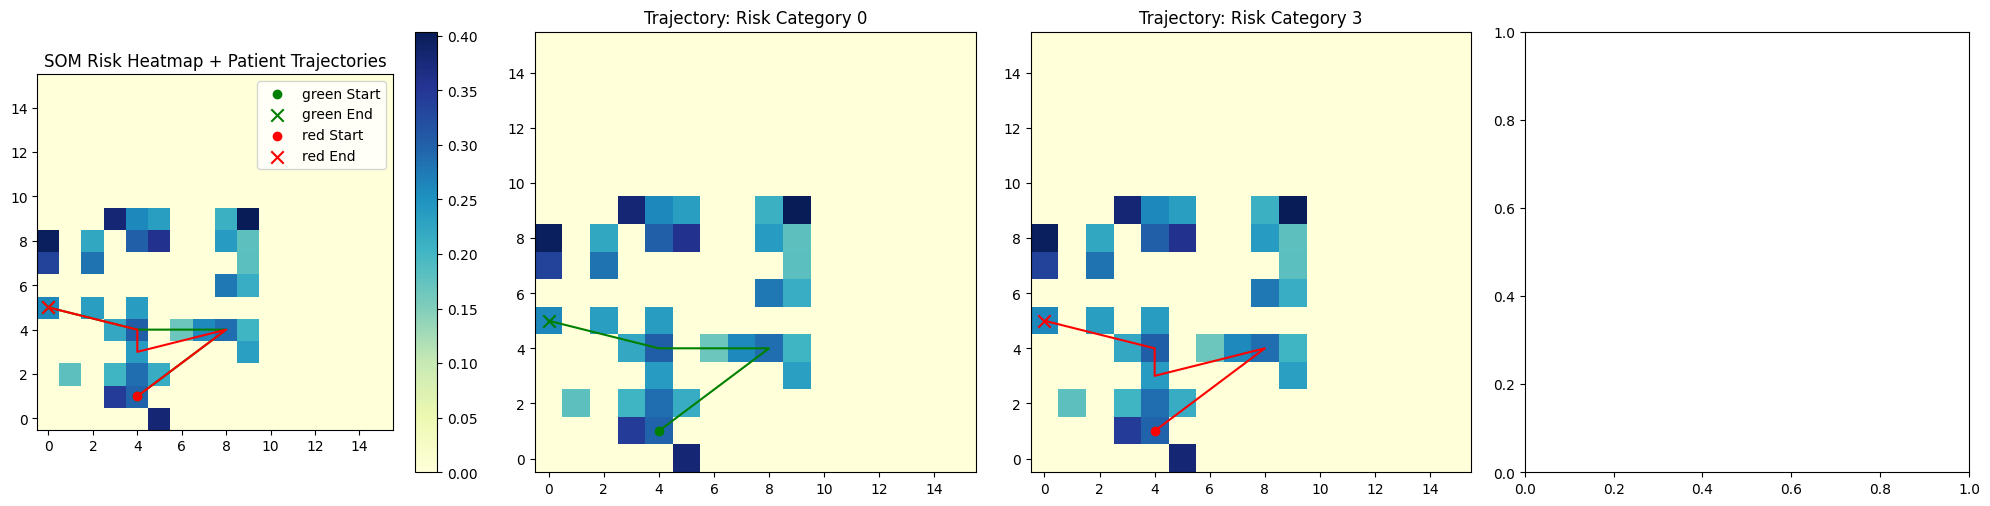

In [23]:
k_tensor, risk_tensor, cat_tensor = collect_k_and_category(model, test_loader, graph_dataset.graph_data, device)

visualize_som_summary(
    k_tensor=k_tensor,
    risk_tensor=risk_tensor,
    category_tensor=cat_tensor,
    grid_size=(16, 16),
    max_per_class=1
)